# Neuroimaing data classification
In this tutorial, we will create a model for classifying task fMRI images from InsCer's ACERTA project. The data contains exams from subjects diagnosed with dyslexia, aswell as healthy controls.


---

###Training the classifier:
This tutorial will be divided in the following sections:

1. Download and extract data files.
2. Create a custom Dataset.
3. Define a Convolutional Neural Network architecture.
4. Model Training and Validation.
5. Test the model on test data.

---






## 1. Download and extract data files

The data for this tutorial is currently made available in Google Drive in the following *url*. 

We can download it using the *gdown* package, and save it as 'data.tar.gz' in the working directory.

In [322]:
import gdown

target_url = 'https://drive.google.com/uc?id=1UILALnGPyKFAsb-3MBzLlKKJnrKQ2FPk'

gdown.download(target_url,'data.tar.gz',quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1UILALnGPyKFAsb-3MBzLlKKJnrKQ2FPk
To: /content/data.tar.gz
102MB [00:00, 139MB/s] 


'data.tar.gz'

Extract files from the tarball:

In [0]:
import os

#set data location
file_path = './data.tar.gz'

#extract tarball
if os.path.exists(file_path):
  import tarfile
  tar = tarfile.open(file_path, "r:gz")
  tar.extractall()
  tar.close()

## 2. Create a custom Dataset.

Now that data has been made available, we can create our custom Dataset. 

We will use the NiBabel package for loading NifTI images and Sci-Kit Learn for splitting datasets into training and validation.


In [0]:
import torch
from torch.utils.data import Dataset
import numpy as np
import nibabel as nib
from sklearn.model_selection import train_test_split
from glob import glob

class ACERTA_dataset(Dataset):
    def __init__(self, set, split=0.8, transform=None):
        
        self.dataset = []

        # set relative file paths
        control_paths = glob('./acerta_task/SCHOOLS/visit1/' + '*nii.gz')
        condition_paths = glob('./acerta_task/AMBAC/visit1/' + '*nii.gz')
        atlas_path = './acerta_task/Masks/HaskinsPeds_NL_atlasRESAMPLED1.0.nii'
        
        # set subject ids and labels
        ids = [i for i in range(len(control_paths+condition_paths))]
        labels = [0] * len(control_paths) + [1] * len(condition_paths)
        
        # load atlas
        atlas_data = nib.load(atlas_path).get_fdata()

        # load image data and mask it with the atlas, choosing whether to discard ROIs.
        file_paths = control_paths + condition_paths
        image_data = load_dataset(file_paths, atlas_data, discard=True)

        # split dataset into training and validation
        train_set, val_set, train_ids, val_ids, \
        train_labels, val_labels  = train_test_split(image_data, ids, labels,
                                                    train_size=split, random_state=42, stratify=labels)

        # build datasets
        if set == 'training':
            print('Loading training data...')
            self.dataset = build_dataset(train_set, train_labels, train_ids)
            
        if set == 'validation':
            print('Loading validation data...')
            self.dataset = build_dataset(val_set, val_labels, val_ids)

    def __getitem__(self, idx):
        data = self.dataset[idx]

        return {
            'input' : torch.FloatTensor(data['image']),
            'label' : data['label'],
            'id'    : data['id']
        }

    def __len__(self):
        return len(self.dataset)


# 2.1 Image loading and processing

When working with task related neuroimages, we can choose to work with hypothesis-driven Regions of Interest (ROIs), so that we focus our analysis on brain regions where brain functionality is considered relevant to the task at hand.

Since we are working with children data, we will make use of the Haskins Pediatric Atlas, which segments the brain into 107 regions.

The **loading_dataset** function loads the data and processes it using the Hasking Pediatric Atlas as a mask, discarding unwanted regions from the image. If discard is not set to True uppon function call, the whole brain volume will be used.

Following the Atlas masking, zscore normalization is applied to the dataset.

In [0]:
def load_dataset(filenames, atlas_data, discard=False):
    '''
    Function dataset preprocessing. 
    The dataset is loaded, masked according to Haskins Pediatric Atlas ROIs, and ZScore normalization is applied.
    '''
    # set the Haskins regions to be discarded
    if discard:
        discarded_regions = [0, 1, 2, 3, 4, 5, 19, 20, 21, 22, 23, 9, 10, 11, 14, 
                            33, 34, 35, 36, 37, 38, 39, 45, 44, 47, 71, 78, 79, 
                            81, 96, 94, 62, 60]

        atlas_data[np.isin(atlas_data, discarded_regions)] = 0
        atlas_data[np.isin(atlas_data, discarded_regions, invert=True)] = 1

    else:
        atlas_data[np.isin(atlas_data, 0, invert=True)] = 1

    # load exam data
    image_data = []
    for i, filename in enumerate(filenames):
        data = nib.load(filename).get_data()
        data = data * atlas_data
        image_data.append(data)

    # zscore normalization
    image_data = (image_data - np.mean(image_data)) / (np.std(image_data) + 1e-6)

    return image_data


The **build_dataset** function reorders the image matrix and creates the actual dataset object.

In [0]:
def build_dataset(image_data,labels,ids):
    '''
    Build the dataset with axis rearrengement. 

    first  (x) = Left-to-Right -- Sagital
    second (y) = Posterior-to-Anterior --Coronal
    third  (z) = Inferior-to-Superior  --Axial [-orient LPI]
    '''
    dataset = []
    for i, input_image in enumerate(image_data):
        input_image = torch.FloatTensor(input_image)
        input_image = input_image.permute(2, 0, 1)

        dataset.append({
            'image': input_image,
            'label': labels[i],
            'id': ids[i]
        })
    
    return dataset

### 3. Define a Convolutional Neural Network architecture.

Next, we define our desired Network architecture. In this example, we will make use of networks based on Oxford's VGG network.

We Will be setting two models, one 13-layers deep and another 7-layers deep, defined using Pytorch's nn.Module. The network's layers are defined in order using nn.Sequential.

 It is important to notice that given the reduced amount of data we are working with, *more layers may cause overfitting.*




In [0]:
import torch.nn.functional as F
import torch.nn as nn

class VGGBased13(nn.Module):
    def __init__(self):
        super(VGGBased13, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(61, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(),

            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(64, 1),

        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x.view(-1, x.shape[1]*x.shape[2]*x.shape[3]))

        return x


In [0]:
class VGGBased7(nn.Module):
    def __init__(self):
        super(VGGBased7, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(61, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),

            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(4),

            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),

            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(4),

        )
        self.classifier = nn.Sequential(
            nn.Linear(384, 512),
            nn.ReLU(),
            nn.Dropout(),
                        
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, 1),
        )


    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x.view(-1, x.shape[1]*x.shape[2]*x.shape[3]))

        return x

## 4. Model Training and Validation.

Next, we start the network training routine.

We begin by instantiating our training and validation sets, defining our training parameters and loading each set with Pytorch's DataLoader.

In [329]:
from torch.utils.data import DataLoader
from torch.autograd import Variable
from collections import defaultdict

training_set = ACERTA_dataset(set='training', split=0.8)

validation_set = ACERTA_dataset(set='validation', split=0.8)

qform_code 5 not valid; setting to 0
sform_code 5 not valid; setting to 0
qform_code 5 not valid; setting to 0
sform_code 5 not valid; setting to 0
qform_code 5 not valid; setting to 0
sform_code 5 not valid; setting to 0
qform_code 5 not valid; setting to 0
sform_code 5 not valid; setting to 0
qform_code 5 not valid; setting to 0
sform_code 5 not valid; setting to 0
qform_code 5 not valid; setting to 0
sform_code 5 not valid; setting to 0
qform_code 5 not valid; setting to 0
sform_code 5 not valid; setting to 0
qform_code 5 not valid; setting to 0
sform_code 5 not valid; setting to 0
qform_code 5 not valid; setting to 0
sform_code 5 not valid; setting to 0
qform_code 5 not valid; setting to 0
sform_code 5 not valid; setting to 0
qform_code 5 not valid; setting to 0
sform_code 5 not valid; setting to 0
qform_code 5 not valid; setting to 0
sform_code 5 not valid; setting to 0
qform_code 5 not valid; setting to 0
sform_code 5 not valid; setting to 0
qform_code 5 not valid; setting to 0
s

Loading training data...


qform_code 5 not valid; setting to 0
sform_code 5 not valid; setting to 0
qform_code 5 not valid; setting to 0
sform_code 5 not valid; setting to 0
qform_code 5 not valid; setting to 0
sform_code 5 not valid; setting to 0
qform_code 5 not valid; setting to 0
sform_code 5 not valid; setting to 0
qform_code 5 not valid; setting to 0
sform_code 5 not valid; setting to 0
qform_code 5 not valid; setting to 0
sform_code 5 not valid; setting to 0
qform_code 5 not valid; setting to 0
sform_code 5 not valid; setting to 0
qform_code 5 not valid; setting to 0
sform_code 5 not valid; setting to 0
qform_code 5 not valid; setting to 0
sform_code 5 not valid; setting to 0
qform_code 5 not valid; setting to 0
sform_code 5 not valid; setting to 0
qform_code 5 not valid; setting to 0
sform_code 5 not valid; setting to 0
qform_code 5 not valid; setting to 0
sform_code 5 not valid; setting to 0
qform_code 5 not valid; setting to 0
sform_code 5 not valid; setting to 0
qform_code 5 not valid; setting to 0
s

Loading validation data...


In [0]:
params = { 'train_batch_size': 4,
           'val_batch_size': 1,
           'learning_rate': 3e-5,
           'weight_decay': 1e-1,
           'epochs': 100,
           'early_stop': 10 }

train_loader = DataLoader(training_set, shuffle=True, drop_last=True,
                             num_workers=8, batch_size=params['train_batch_size'])

val_loader = DataLoader(validation_set, shuffle=False, drop_last=False,
                        num_workers=8, batch_size=params['val_batch_size'])
           

# Loss function and Optimizer:

Since we are working with binary classification, we will opt for Binary Cross Entropy as our loss function.

We make use of Pytorch's BCEWithLogitsLoss, which already includes a sigmoid function and is referenced in the documentation as being more robust.

For optimization we will be using Adam, which is the go to choice for training Deep Learning Models. Weight decay is set to a high value in order to increase regularization.


In [0]:
criterion = nn.BCEWithLogitsLoss()

model = VGGBased7()

optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'],
                             weight_decay=params['weight_decay'])


### Begin training:

Next, we train our network by iterating over training and validation datasets for the given number of epochs. An early stop flag is also set, so the model finishes once it stops learning for a given number of epochs.

The trained model state is saved in the checkpoints folder as *checkpoint.pth*

In [0]:
# set path for saving trained models
checkpoint = './acerta_task/checkpoints/checkpoint.pth'


best_loss = np.inf
loss_list = []

# looping over epochs
for e in range(params['epochs']):
    print('Epoch:',e)
    
    # set the model to training model (computes gradients)
    model.train()
    
    losses = []
    accuracy = []
    predictions = defaultdict(list)

    # iterate over train_loader object
    for i, data in enumerate(train_loader):

        # load input and label for the batch
        input_data = Variable(data['input']).float()
        label = Variable(data['label']).float()

        # forward pass
        output = model(input_data)
        
        # compute loss
        loss = criterion(output, label.unsqueeze(1))        
        losses.append(loss.item())
        
        # zero parameters gradient
        optimizer.zero_grad()
        
        # backpropagation
        loss.backward()

        # optimization
        optimizer.step()

        # compute accuracy
        prediction = (output > 0).float()
        correct = (prediction == label.reshape(-1,1)).float()
        total_correct = correct.sum()
        accuracy.append((total_correct / label.shape[0]))

    print('Training Loss:   {:.3f} - Accuracy: {:.3f}'.format(np.mean(losses),torch.mean(torch.stack(accuracy))))
   
   # set the model for validation (no gradients)
    model.eval()

    val_loss = []
    accuracy = []
    predictions = defaultdict(list)

    # iterate over val_loader object
    for i, data in enumerate(val_loader):
        
        # loads input and label for the batch
        input_data = Variable(data['input'])
        label = Variable(data['label']).float()

        # forward pass
        output = model(input_data)

        # compute validation loss
        loss = criterion(output, label.unsqueeze(1))
        val_loss.append(loss.item())

        # compute accuracy
        prediction = (output > 0).float()
        correct = (prediction == label.reshape(-1,1)).float()
        total_correct = correct.sum()
        accuracy.append(total_correct / label.shape[0])

    # early stop
    loss_list.append(np.mean(val_loss))
    if loss_list[-1] < best_loss:
        best_loss = loss_list[-1]
        loss_list = []
    if len(loss_list) == params['early_stop']:
        print('Early stopping.')
        print('Validation Loss: {:.3f} - Accuracy: {:.3f}'.format(np.mean(val_loss), torch.mean(torch.stack(accuracy))))
        torch.save(model.state_dict(), checkpoint)    
        break

    print('Validation Loss: {:.3f} - Accuracy: {:.3f}'.format(np.mean(val_loss),torch.mean(torch.stack(accuracy))))
    torch.save(model.state_dict(), checkpoint)
    
print('Finished training.')

## 5. Testing the model

After training our model, we can test its performance on test data. For this, we repeat much of the loading processes used for training. 

In [0]:
class TEST_dataset(Dataset):
    def __init__(self):
      
        self.dataset = []

        # set relative file paths
        data_path = './acerta_task/'
        control_paths = glob(data_path + 'TEST/' + '*SCH*.nii.gz')
        condition_paths = glob(data_path + 'TEST/' + '*AMBAC*.nii.gz')
        atlas_path = './acerta_task/Masks/HaskinsPeds_NL_atlasRESAMPLED1.0.nii'

        # set subject ids and labels
        ids = [i for i in range(len(control_paths+condition_paths))]
        labels = [0] * len(control_paths) + [1] * len(condition_paths)

        # load atlas data
        atlas_data = nib.load(atlas_path).get_fdata()

        #load exam data
        file_paths = control_paths + condition_paths
        image_data = load_dataset(file_paths, atlas_data, discard=True)

        self.dataset = build_dataset(image_data, labels, ids)

    def __getitem__(self, idx):
        data = self.dataset[idx]

        return {
            'input' : torch.FloatTensor(data['image']),
            'label' : data['label'],
            'id'    : data['id']
        }


    def __len__(self):
        return len(self.dataset)

Load the test dataset and create DataLoader object:



In [0]:
test_set = TEST_dataset()

test_loader = DataLoader(test_set, shuffle=False, drop_last=False,
                        num_workers=8, batch_size=1)

Next we load our saved model parameters:


In [0]:
saved_model = './acerta_task/checkpoints/best_model.pth'
# saved_model = './acerta_task/checkpoints/checkpoint.pth'

model = VGGBased13()
model.load_state_dict(torch.load(saved_model))
model.eval()

Make a forward pass into the trained model with the test data and compute accuracy:

In [342]:
accuracy = []
predictions = defaultdict(list)
control_result = []
condition_result = []

for i, data in enumerate(test_loader):
    input_data = Variable(data['input'])
    output = model(input_data)
    label = Variable(data['label']).float()

    prediction = (output > 0).float()
    correct = (prediction == label.reshape(-1,1)).float()
    total_correct = correct.sum()
    accuracy.append(total_correct / label.shape[0])

    if int(label) == 0:
        control_result.append(int(total_correct))
    else:
        condition_result.append(int(total_correct))

print('Test Accuracy: {:.3f}'.format(torch.mean(torch.stack(accuracy))))


Test Accuracy: 0.727


Plot the classification results for each condition and for the whole test dataset:

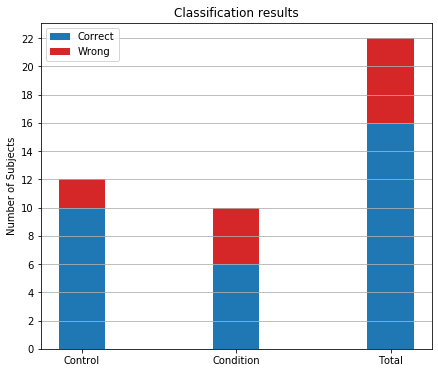

In [343]:
import numpy as np
import matplotlib.pyplot as plt


correct_values = (np.sum(control_result), np.sum(condition_result),np.sum(condition_result+control_result))
total_values = (len(control_result)-correct_values[0],len(condition_result)-correct_values[1],len(control_result+condition_result)-correct_values[2])
ind = [0, 0.5, 1]    # the x locations for the groups
width = 0.15       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, correct_values, width,color='tab:blue')
p2 = plt.bar(ind, total_values, width, bottom=correct_values, color='tab:red')

plt.ylabel('Number of Subjects')
plt.title('Classification results')
plt.xticks(ind, ('Control', 'Condition', 'Total'))
plt.yticks(np.arange(0, 24, 2))
plt.legend((p1[0], p2[0]), ('Correct', 'Wrong'))
plt.rcParams["figure.figsize"] = (7,6)
plt.grid(axis='y')

plt.show()